# MELD Dataset

I this notebook I prepare and wrangle the MELD training data then explore the nature of common audio features including melspectrogram, mfcc, and chroma for the purpose of emotion classification.

## Training Data

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython 
import librosa as lb
import seaborn as sns

In [2]:
train_df = pd.read_csv('data/train_sent_emo.csv')
train_df.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


## Test Data

In [4]:
test_df = pd.read_csv('data/test_sent_emo.csv')
test_df.head(5)

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        2610 non-null   int64 
 1   Utterance     2610 non-null   object
 2   Speaker       2610 non-null   object
 3   Emotion       2610 non-null   object
 4   Sentiment     2610 non-null   object
 5   Dialogue_ID   2610 non-null   int64 
 6   Utterance_ID  2610 non-null   int64 
 7   Season        2610 non-null   int64 
 8   Episode       2610 non-null   int64 
 9   StartTime     2610 non-null   object
 10  EndTime       2610 non-null   object
dtypes: int64(5), object(6)
memory usage: 224.4+ KB


## Data Wrangling and Exploration

### Missing Values

In [6]:
def df_missing_any(df) -> bool:
    # isna: NaN in numeric arrays, None or NaN in object arrays, NaT in datetimelike
    return df.isna().values.any()

assert not df_missing_any(train_df)
assert not df_missing_any(test_df)

### Construct unique id

In [46]:
def add_dia_utt(dataframe):
    # feature vectors and audtio files are stored by 'dia_utt' so create that in the df
    cols = ['Dialogue_ID', 'Utterance_ID']
    dataframe['dia_utt'] = dataframe[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

add_dia_utt(train_df)
print(train_df['dia_utt'])
assert train_df['dia_utt'].is_unique

0           0_0
1           0_1
2           0_2
3           0_3
4           0_4
         ...   
9984    1038_13
9985    1038_14
9986    1038_15
9987    1038_16
9988    1038_17
Name: dia_utt, Length: 9989, dtype: object


In [47]:
add_dia_utt(test_df)
print(test_df['dia_utt'])
assert test_df['dia_utt'].is_unique

0          0_0
1          0_1
2          0_2
3          1_0
4          1_1
         ...  
2605    279_11
2606    279_12
2607    279_13
2608    279_14
2609    279_15
Name: dia_utt, Length: 2610, dtype: object


### Column-wise Exploration

#### Utterance

count    9989.000000
mean       40.528381
std        31.953528
min         1.000000
25%        16.000000
50%        32.000000
75%        58.000000
max       327.000000
Name: Utterance_len, dtype: float64


Text(0.5, 1.0, 'Frequency vs. Utterance length')

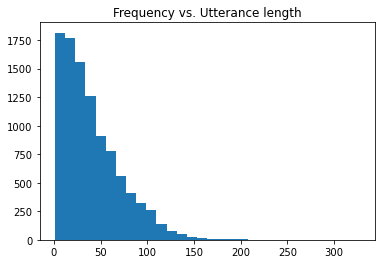

In [8]:
train_df['Utterance_len'] = train_df['Utterance'].apply(len)
print(train_df.Utterance_len.describe())
plt.hist(train_df.Utterance_len, bins=30)
plt.title('Frequency vs. Utterance length')

Text(0.5, 1.0, 'Frequency vs. Small Utterance length')

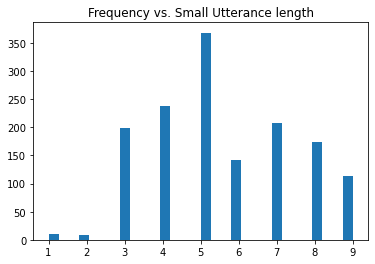

In [163]:
plt.hist(train_df.Utterance_len[train_df.Utterance_len < 10], bins=30)
plt.title('Frequency vs. Small Utterance length')

In [9]:
train_df.Utterance[train_df.Utterance_len < 3].value_counts()
# Check out the outlier short utterances

I     10
No     2
Is     1
Wh     1
!      1
We     1
Hi     1
Eh     1
In     1
It     1
Name: Utterance, dtype: int64

In [10]:
import librosa
import os

short_audio_paths = []
for i, id in train_df.dia_utt[train_df.Utterance_len < 3].iteritems():
    path = 'data/audio/' + id + '.wav'
    short_audio_paths.append(os.path.join(os.getcwd(), path))
    
    
def display_audio_from(path: str):
    audio, sr = librosa.load(fp)
    IPython.display.Audio(audio, rate=sr)
    
print(len(short_audio_paths))

20


In [11]:
for sap in short_audio_paths:
    audio, sr = librosa.load(sap)
    IPython.display.display(IPython.display.Audio(audio, rate=sr))

# indices 6, 7 seem too short in length, so I will have to check the audio lengths

Text(0.5, 1.0, 'Frequency vs. Big Utterance length')

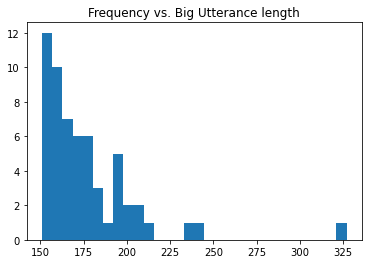

In [165]:
# Looks like there are some longer dialogues thay may have to be split in smaller chunks
plt.hist(train_df.Utterance_len[train_df.Utterance_len > 150], bins=30)
plt.title('Frequency vs. Big Utterance length')

#### Speaker

In [111]:
speaker_counts = train_df['Speaker'].value_counts()
speaker_counts

Joey                1509
Ross                1459
Rachel              1435
Phoebe              1321
Monica              1299
                    ... 
Phoebe/Waitress        1
Vince                  1
Gary Collins           1
Hold Voice             1
Front Desk Clerk       1
Name: Speaker, Length: 260, dtype: int64

In [118]:
top_speakers = speaker_counts[speaker_counts > 100]
top_speakers

Joey        1509
Ross        1459
Rachel      1435
Phoebe      1321
Monica      1299
Chandler    1283
Name: Speaker, dtype: int64

In [120]:
100 * sum(top_speakers) / sum(speaker_counts)
# 83 % of the data comes from the 6 main characters, this could lead to overfitting on their voices

83.15146661327461

#### Emotion

Emotion is the main DV I wish to predict

In [13]:
emo_cnts = train_df['Emotion'].value_counts(normalize=True)
emo_cnts * 100

neutral     47.151867
joy         17.449194
surprise    12.063270
anger       11.102212
sadness      6.837521
disgust      2.712984
fear         2.682951
Name: Emotion, dtype: float64

In [17]:
# highlighting imbalance with largest class
emo_cnts.neutral / emo_cnts 

# Most of the contemporary works in class imbalance concentrate on imbalance ratios
# ranging from 1:4 up to 1:100
# https://link.springer.com/article/10.1007/s13748-016-0094-0

neutral      1.000000
joy          2.702238
surprise     3.908714
anger        4.247069
sadness      6.896047
disgust     17.380074
fear        17.574627
Name: Emotion, dtype: float64

The emotion classes are somewhat imbalanced. Neutral is overrepresented, while sadness, disgust, and fear are underrepresented. For instance, neutral occurs 17x more than digust and fear. I will consider: 

- over-sampling since dataset size is on the smaller end
- testing random and non-random (e.g. stratified) sampling schemes.
- decision trees often perform well on imbalanced datasets
- Penalized Models
- Combining the negative emotions into 1 group to simplify the problem and increase the data per class

#### Sentiment

In [19]:
sent_counts = train_df['Sentiment'].value_counts(normalize=True)
sent_counts

# The sentiment classes are fairly balanced, 
# i.e. difference b/w neutral and positive is 2x 

neutral     0.471519
negative    0.294824
positive    0.233657
Name: Sentiment, dtype: float64

#### Dialogue_ID

In [20]:
dialog_counts = train_df['Dialogue_ID'].value_counts(sort=True)
print('total dialogs ', len(dialog_counts))
print(dialog_counts)

total dialogs  1038
523    24
54     24
450    24
649    24
530    24
       ..
987     1
790     1
581     1
490     1
742     1
Name: Dialogue_ID, Length: 1038, dtype: int64


Utterance distribution across dialogues is reasonable. Most occurrences is 24 out of 1038 for some dialogs.

#### Utterance_ID

In [21]:
# Based on Dialog id counts this should range from 0-23
train_df['Utterance_ID'].value_counts()

0     1028
1      965
2      899
3      848
4      803
5      733
6      676
7      603
8      536
9      483
10     433
11     378
12     322
13     282
14     246
15     215
16     157
17     123
18      93
19      69
20      48
21      30
22      14
23       5
Name: Utterance_ID, dtype: int64

#### Season

In [22]:
train_df['Season'].value_counts().sort_index()
# for some reason seasons 2, 9 are slightly underrepresented

1    1402
2     289
3    1609
4    1129
5    1265
6    1317
7    1380
8    1108
9     490
Name: Season, dtype: int64

#### Episode

In [23]:
train_df['Episode'].value_counts().sort_index()

1     396
2     469
3     368
4     440
5     630
6     417
7     364
8     218
9     294
10    456
11    440
12    586
13    334
14    429
15    365
16    259
17    410
18    388
19    355
20    361
21    398
22    392
23    686
24    381
25    153
Name: Episode, dtype: int64

Summary of data exploration

- there are some outlier utterance in terms of length, small and large
- 6 speakers comprise 83% of the data
- 17x class imbalance b/w fear, digust and neutral

### Encoding

__Must convert the emotion labels to numeric. Use ordinal encoding__


In [241]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

train_df['emotion_class'] = label_encoder.fit_transform(train_df['Emotion'])
train_df[['Emotion', 'emotion_class']].head()

,Emotion,emotion_class
0,neutral,4
1,neutral,4
2,neutral,4
3,neutral,4
4,surprise,6


In [230]:
test_df['emotion_class'] = label_encoder.transform(test_df['Emotion'])
test_df[['Emotion', 'emotion_class']].head()

,Emotion,emotion_class
0,surprise,6
1,anger,0
2,neutral,4
3,neutral,4
4,joy,3


# Audio File Wrangling and Exploration

In [68]:
import os
meld_path = '/Users/home/Desktop/ml-eng/datasets/MELD'
meld_audio_rel_path = 'MELD.Raw/train/train_splits'
audio_path = os.path.join(meld_path, meld_audio_rel_path)
mp4_paths = [os.path.join(audio_path, fname) for fname in os.listdir(audio_path)]
print(len(mp4_paths))
print(mp4_paths[0])

9989
/Users/home/Desktop/ml-eng/datasets/MELD/MELD.Raw/train/train_splits/dia47_utt11.mp4


#### Convert mp4 to mp3

In [76]:
import moviepy.editor as mp

out_path = 'data/audio/'
finished = set(f.split('.')[0] for f in os.listdir(out_path))
print('already finished: ', len(finished))

fails = []
for path in mp4_paths:
    fname = path.split('/')[-1].split('.')[0]
    fname = fname.replace('dia', '').replace('utt', '')
    if fname in finished:
        continue
        
    print('processing: ' + fname)
    
    try:
        clip = mp.VideoFileClip(path)

        # pick highest quality kwargs based on https://zulko.github.io/moviepy/ref/AudioClip.html
        clip.audio.write_audiofile(out_path + fname + '.wav', nbytes=4, codec='pcm_s32le', bitrate='3000k')
    except Exception as e:
        fails.append(e)
        

print(f'Finished with {len(fails)} failure(s): {fails}')

already finished 9988
processing: 125_3
Finished with 1 failure(s): [OSError('MoviePy error: failed to read the duration of file /Users/home/Desktop/ml-eng/datasets/MELD/MELD.Raw/train/train_splits/dia125_utt3.mp4.\nHere are the file infos returned by ffmpeg:\n\nffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers\n  built with Apple clang version 11.0.0 (clang-1100.0.33.8)\n  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-

In [78]:
wav_paths = [os.path.join(out_path, fname) for fname in os.listdir(out_path)]
print(len(wav_paths))
print(wav_paths[:3])

9988
['data/audio/813_8.wav', 'data/audio/141_5.wav', 'data/audio/902_5.wav']


Load all wav files into a dict indexed by id

In [319]:
from random import sample
import librosa


def path_to_id(path: str) -> str:
    return path.split('/')[-1].split('.')[0]


def load_audio(paths: list, rows: list, sample_size: int) -> dict:
    for path in sample(paths, sample_size):
        uid = path_to_id(path)
        audio, sr = librosa.load(path)
        rows.append([uid, audio, sr])
    
rows = []
%time load_audio(wav_paths, rows, sample_size=len(wav_paths))  # loading entire set will take around 18 minutes

CPU times: user 18min 44s, sys: 16.9 s, total: 19min 1s
Wall time: 19min 38s


Standardize audio to have mean zero and unit variance

In [352]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler() this is a PITA

# Standardize single signal
def standard_scale(X):
    return (X - np.mean(X)) / np.std(X)

X = np.array(rows[0][1])
print('before ', X[:5])
print('stats ', np.mean(X), np.std(X))
X_scaled = standard_scale(X)
print('\nafter ', X_scaled[:5])
print('stats ', np.mean(X_scaled), np.std(X_scaled))

before  [1.0675072e-05 1.4261603e-03 2.2374850e-03 1.7696338e-03 3.9989792e-04]
stats  -2.0214678e-05 0.030746298

after  [0.00100467 0.04704225 0.07342996 0.05821346 0.01366384]
stats  -4.589087e-09 0.99999994


As shown the data changes a bit in mu and sigma

In [353]:
# standardize all signals
for i, row in enumerate(rows):
    rows[i][1] = standard_scale(row[1])
    
    
print(rows[:3])

[['1005_15', array([1.0046657e-03, 4.7042251e-02, 7.3429964e-02, ..., 7.9159307e-01,
       6.9737458e-01, 6.5746706e-04], dtype=float32), 22050], ['51_3', array([-0.00390739,  0.00575748,  0.00597218, ..., -0.00591504,
        0.00031518, -0.00359621], dtype=float32), 22050], ['716_5', array([0.05023927, 0.08569281, 0.07713702, ..., 0.00269042, 0.00269042,
       0.00269042], dtype=float32), 22050]]


Construct new DF to focus on the feature processing

In [355]:
audio_df = pd.DataFrame(rows)
audio_df.columns = ['dia_utt', 'audio', 'sr']
audio_df.set_index('dia_utt')
audio_df.head(3)

,dia_utt,audio,sr
0,1005_15,"[0.0010046657, 0.04704225, 0.073429964, 0.0582...",22050
1,51_3,"[-0.0039073857, 0.0057574795, 0.005972182, -0....",22050
2,716_5,"[0.05023927, 0.08569281, 0.077137016, 0.080168...",22050


In [356]:
train_df.set_index('dia_utt')
train_df.dia_utt = train_df.dia_utt.astype(str)
audio_df.dia_utt = audio_df.dia_utt.astype(str)

# join labels to the audio data
sample_df = audio_df.merge(train_df[['dia_utt', 'Emotion', 'emotion_class']], on='dia_utt')
sample_df.head()

,dia_utt,audio,sr,Emotion,emotion_class
0,1005_15,"[0.0010046657, 0.04704225, 0.073429964, 0.0582...",22050,neutral,4
1,51_3,"[-0.0039073857, 0.0057574795, 0.005972182, -0....",22050,disgust,1
2,716_5,"[0.05023927, 0.08569281, 0.077137016, 0.080168...",22050,anger,0
3,184_20,"[-0.0061293724, -0.010783453, -0.006978109, -0...",22050,neutral,4
4,692_1,"[-0.17367263, -0.08620572, 0.013713178, -0.047...",22050,neutral,4


## EDA of audio files

(array([7.790e+02, 2.108e+03, 2.300e+03, 1.553e+03, 1.002e+03, 5.870e+02,
        4.140e+02, 3.550e+02, 2.570e+02, 1.890e+02, 1.340e+02, 9.200e+01,
        5.700e+01, 5.600e+01, 3.300e+01, 2.200e+01, 1.000e+01, 1.500e+01,
        6.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([  1764.  ,  19836.18,  37908.36,  55980.54,  74052.72,  92124.9 ,
        110197.08, 128269.26, 146341.44, 164413.62, 182485.8 , 200557.98,
        218630.16, 236702.34, 254774.52, 272846.7 , 290918.88, 308991.06,
        327063.24, 345135.42, 363207.6 , 381279.78, 399351.96, 417424.14,
        435496.32, 453568.5 , 471640.68, 489712.86, 507785.04, 525857.22,
      

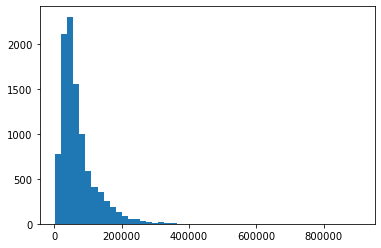

In [357]:
import matplotlib.pyplot as plt

sample_df['audio_len'] = sample_df['audio'].apply(len)
plt.hist(sample_df['audio_len'], bins=50)

In [358]:
sample_df['audio_len'].describe()

count      9988.000000
mean      69564.558070
std       53545.026138
min        1764.000000
25%       34563.750000
50%       54684.000000
75%       86877.000000
max      905373.000000
Name: audio_len, dtype: float64

Obtain 10 samples of each emotion 
calculate the coefficients (e.g., 10) to go from a time series to a spectogram
put the features through PCA, are there any clusters?

https://stackoverflow.com/questions/56911774/mfcc-feature-extraction-librosa

https://data-flair.training/blogs/python-mini-project-speech-emotion-recognition/

Questions to answer
- what length audio file is optimal?
- what features are useful?

### Mel-scaled spectrogram

- time-frequency representation of sound
- sampled into a number of points around equally spaced times and frequencies on a Mel frequency scale
- Mel frequency scale: mel = 2595 * log10 (1 + hertz / 700)
- constructed such that sounds of equal distance from each other on the Mel Scale, also sound to humans as they are equal distance from on another
- in contrast to Hz scale where 500-1000 hz is obvious but 7500 to 8000 barely noticeable


In [360]:
# select sample
dia_utt, y, sr, label, y_len, clz = sample_df.head(1).values[0]
print('id ', dia_utt, '\nsize ', y_len, '\nlabel ', label)

id  1005_15 
size  4 
label  neutral


In [361]:
IPython.display.display(IPython.display.Audio(y, rate=sr))

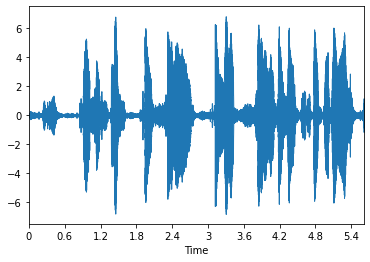

In [362]:
from librosa.display import waveplot
waveplot(y, sr=sr)

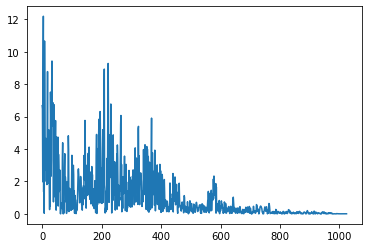

In [363]:
# apply FFT
import numpy as np
import matplotlib.pyplot as plt

n_fft = 2048
D = np.abs(librosa.stft(y[:n_fft], n_fft=n_fft, hop_length=n_fft + 1))
plt.plot(D)

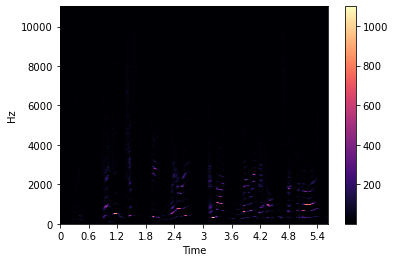

In [364]:
# FFT + time windows
hop_length = 512
D = np.abs(librosa.stft(y, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

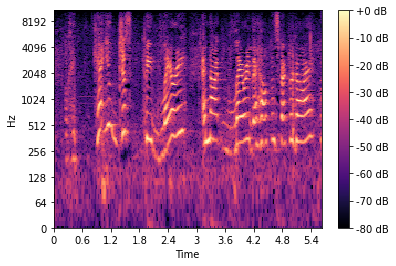

In [365]:
# windows transformed to DB
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

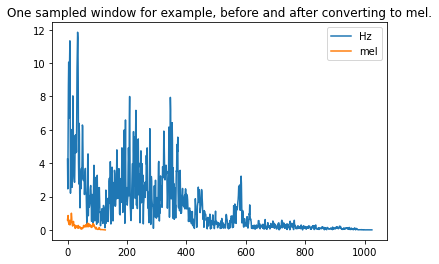

In [366]:
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

plt.plot(D[:, 1]);
plt.plot(mel.dot(D[:, 1]));
plt.legend(labels=['Hz', 'mel']);
plt.title('One sampled window for example, before and after converting to mel.');

(128, 242)
(128, 242)


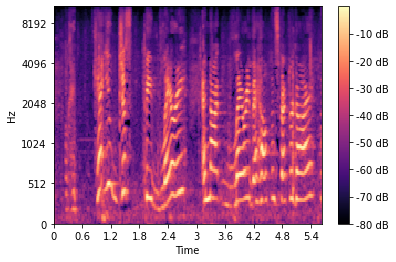

In [367]:
# Create melspectrogram of 128 features for each time window
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_db = librosa.power_to_db(S, ref=np.max)
print(S.shape)
print(S_db.shape)

librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

Recap
- Separate to windows: Sample the input with windows of size n_fft=2048, making hops of size hop_length=512 each time to sample the next window.
- Compute FFT (Fast Fourier Transform) for each window to transform from time domain to frequency domain.
- Generate a Mel scale: Take the entire frequency spectrum, and separate it into n_mels=128 evenly spaced frequencies.
- And what do we mean by evenly spaced? not by distance on the frequency dimension, but distance as it is heard by the human ear.
- Generate Spectrogram: For each window, decompose the magnitude of the signal into its components, corresponding to the frequencies in the mel scale.

source: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

### Mel-frequency cepstral coefficients (MFCCs)

- representation of the short-term power spectrum of a sound based on a linear cosine transform of a log power spectrum on a mel scale of frequency
- Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC.[1] They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression
(https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)

- small set of features (usually 10-20) which concisely describe the overall shape of a spectral envelope

In [368]:
mfccs = librosa.feature.mfcc(y, sr=sr)
print('{} MFCCs over {} frames'.format(*mfccs.shape))

20 MFCCs over 242 frames


The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.
(source: https://musicinformationretrieval.com/mfcc.html)

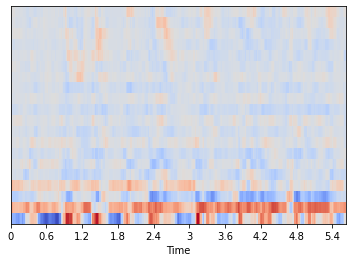

In [369]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [370]:
# feature scaling to mean 0 and variance 1
import sklearn
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print(mfccs.mean(axis=1))  # close to 0
print(mfccs.var(axis=1))  # close to 1

[-3.94080280e-09  0.00000000e+00  0.00000000e+00  1.57632112e-08
  0.00000000e+00 -7.88160559e-09  7.88160559e-09 -1.08372085e-08
  0.00000000e+00 -1.18224088e-08  0.00000000e+00  9.85200699e-10
 -7.88160559e-09  7.88160559e-09  0.00000000e+00 -1.57632112e-08
  1.57632112e-08  0.00000000e+00  0.00000000e+00  7.88160559e-09]
[1.        1.        0.9999999 1.0000001 1.0000001 1.        1.0000001
 0.9999999 1.0000001 1.        1.        1.        0.9999999 0.9999998
 1.0000001 1.0000001 1.        1.        1.0000001 1.0000001]


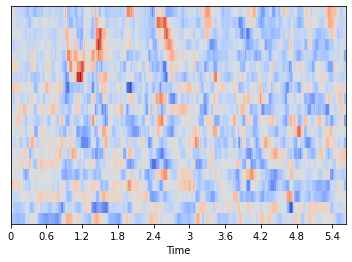

In [371]:
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma

http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/generated/librosa.feature.chroma_stft.html

https://musicinformationretrieval.com/chroma.html

In [372]:
import matplotlib.pyplot as plt

def plot_chroma(chroma, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()

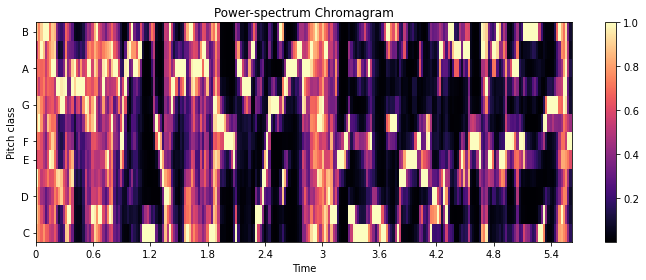

In [373]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

plot_chroma(chroma, 'Power-spectrum Chromagram')

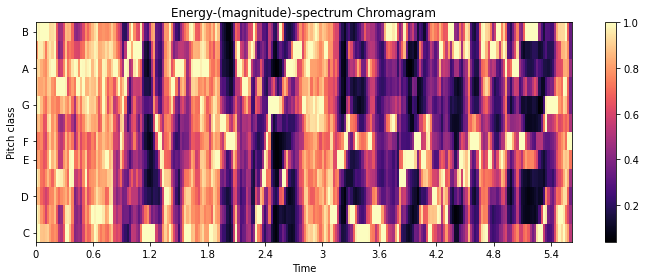

In [374]:
S = np.abs(librosa.stft(y))
chroma = librosa.feature.chroma_stft(S=S, sr=sr)
title = 'Energy-(magnitude)-spectrum Chromagram'

plot_chroma(chroma, title)

In [375]:
def extract_melspectrogram(result, y, sr):
    X = np.mean(librosa.feature.melspectrogram(y, sr=sr).T, axis=0)
    return np.hstack((result, X))


def extract_mfcc(result, y, sr, n_mfcc=20):
    X = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)
    return np.hstack((result, X))


def extract_chroma(result, y, sr):
    stft = np.abs(librosa.stft(y))
    X = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    return np.hstack((result, X))
    

def extract_features(y, sr):
    result = np.array([])
    result = extract_melspectrogram(result, y, sr)
    result = extract_mfcc(result, y, sr)  
    result = extract_chroma(result, y, sr)
    return result


In [376]:
feats = extract_melspectrogram(np.array([]), y, sr)
len(feats)

128

In [377]:
feats = extract_mfcc(feats, y, sr)
len(feats)

148

In [378]:
feats = extract_chroma(feats, y, sr)
len(feats)

160

In [379]:
sample_df.head()

,dia_utt,audio,sr,Emotion,emotion_class,audio_len
0,1005_15,"[0.0010046657, 0.04704225, 0.073429964, 0.0582...",22050,neutral,4,123701
1,51_3,"[-0.0039073857, 0.0057574795, 0.005972182, -0....",22050,disgust,1,66591
2,716_5,"[0.05023927, 0.08569281, 0.077137016, 0.080168...",22050,anger,0,52920
3,184_20,"[-0.0061293724, -0.010783453, -0.006978109, -0...",22050,neutral,4,27122
4,692_1,"[-0.17367263, -0.08620572, 0.013713178, -0.047...",22050,neutral,4,121496


In [380]:
# construct X_train
X_train = []
for i, r in sample_df.iterrows():
    X_train.append(extract_features(r.audio, r.sr))
    if not i % len(sample_df) / 10:
        print(100*i/len(sample_df))
    
X_train = np.array(X_train)
print(X_train.shape)

0.0
5.006007208650381
10.012014417300762
15.01802162595114
20.024028834601523
25.0300360432519
30.03604325190228
35.042050460552666
40.04805766920305
45.05406487785343
50.0600720865038
55.06607929515418
60.07208650380456
65.07809371245494
70.08410092110533
75.0901081297557
80.0961153384061
85.10212254705647
90.10812975570686
95.11413696435723
(9988, 160)


In [381]:
y_train = sample_df['emotion_class']
print(y_train.shape)

(9988,)


In [382]:
# check for nan
assert not np.isnan(sum(X_train.ravel()))

In [383]:
melspectrogram = X_train[:, :128]
mfcc = X_train[:, 128: 148]
chroma = X_train[:, 148:]

In [389]:
## Feature EDA
unq = train_df.Emotion.unique()
print(unq)
print(label_encoder.transform(unq))

['neutral' 'surprise' 'fear' 'sadness' 'joy' 'disgust' 'anger']
[4 6 2 5 3 1 0]


In [390]:
# split the features based on the label, look for hallmarks
# Use loc
# melspectrogram.loc[]

# df.loc[df['column_name'] == some_value]

### Explore Melspectrogram

In [391]:
mel_df = pd.DataFrame(melspectrogram)
mel_df['emotion_class'] = y_train
mel_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,emotion_class
count,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,...,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,29.762620,127.118012,195.636807,235.568362,364.053167,385.501789,478.478052,737.119561,759.221362,742.593841,...,1.524302,1.253537,0.984352,0.798142,0.644171,0.521372,0.355501,0.114948,0.009186,3.555967
std,140.481783,492.678963,606.286043,534.512468,720.915006,676.051947,770.971169,1021.142673,1083.130252,1123.778929,...,4.602317,4.179334,3.464298,2.946101,2.582288,2.346465,1.642810,0.598156,0.067361,1.629916
min,0.012937,0.034918,0.083201,0.224685,0.282380,0.206615,0.340758,0.197775,0.203700,0.174588,...,0.000187,0.000167,0.000163,0.000151,0.000185,0.000134,0.000097,0.000038,0.000005,0.000000
25%,2.293255,6.407935,12.300305,16.289227,29.038079,42.796219,81.638329,150.984463,156.014977,152.105949,...,0.148153,0.121369,0.093514,0.078730,0.064360,0.047354,0.030812,0.009544,0.000748,3.000000
50%,5.418278,18.290672,34.161680,49.274126,100.249985,146.581352,228.975563,394.583466,398.340164,381.875137,...,0.421420,0.331481,0.256847,0.210301,0.170268,0.122266,0.080199,0.024417,0.001964,4.000000
75%,13.734890,61.098820,121.964037,193.671310,374.984032,438.918686,566.517929,903.489868,920.031586,873.125046,...,1.265089,1.006448,0.769929,0.633478,0.503113,0.366516,0.236837,0.072633,0.005519,4.000000
max,4273.603027,12175.238281,11567.621094,8326.361328,10455.910156,11383.530273,15201.757812,14697.314453,15590.220703,19891.650391,...,188.843491,157.577194,129.737930,129.850418,131.429276,134.298965,60.362381,25.741436,4.162612,6.000000


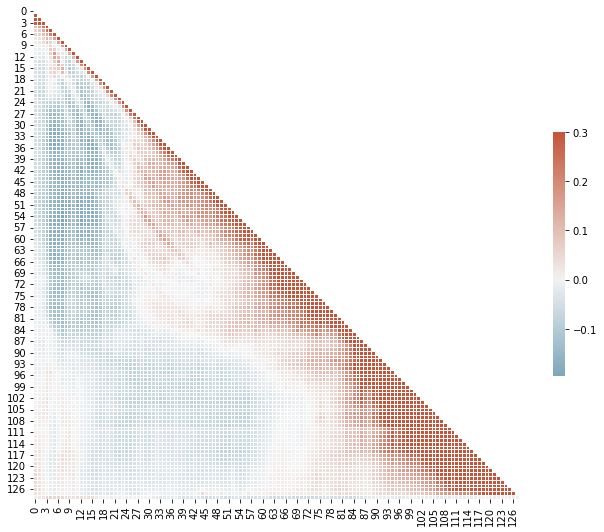

In [392]:
mel_corr = mel_df.corr()

def sea_corr_plot(corr):
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
sea_corr_plot(mel_corr)

In [412]:
def print_high_corr(corr, thresh=0.05):
    #Correlation with output variable
    # features with high correlation to output variable 
    cor_target = abs(corr["emotion_class"]) 
    cor_target.drop('emotion_class', inplace=True)
    print(cor_target[cor_target > thresh])
    
    
# seems like only a few weakly correlated features     
print_high_corr(mel_corr)

3     0.056182
4     0.057789
5     0.054238
6     0.054029
7     0.050784
45    0.061773
47    0.052374
50    0.051132
51    0.053007
57    0.056385
62    0.057191
63    0.057616
64    0.055876
65    0.060079
66    0.055068
67    0.058369
68    0.059333
69    0.062688
70    0.064084
71    0.057400
72    0.060878
73    0.066868
74    0.061072
75    0.050127
80    0.054209
81    0.060906
82    0.059093
83    0.066381
84    0.055924
Name: emotion_class, dtype: float64


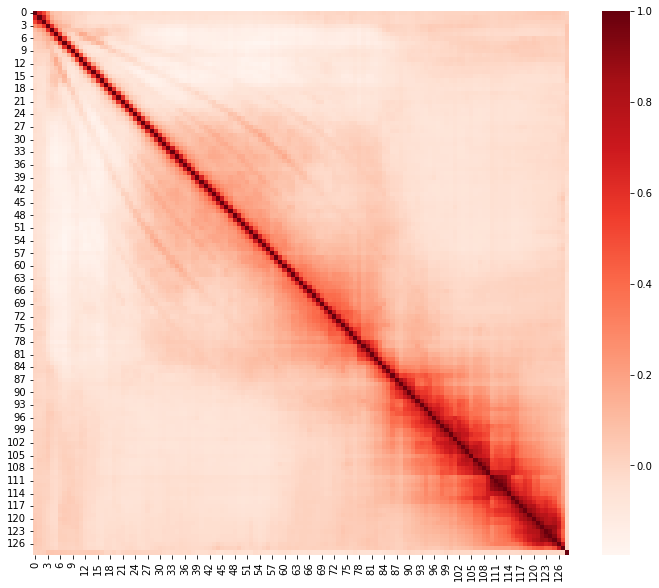

In [394]:
plt.figure(figsize=(12,10))
sns.heatmap(mel_corr, cmap=plt.cm.Reds)
plt.show()

In [396]:
from sklearn.decomposition import PCA

def try_pca(df, scale=False, sig=3):
    print('c', 'explained', 'min')
    for c in range(4, 30, 1):
        pca = PCA(n_components=c)
        pca.fit(df)
        evr = pca.explained_variance_ratio_
        print(c, round(sum(evr), sig), round(min(evr), sig))
        # print(pca.singular_values_)
        
try_pca(mel_df)

c explained min
4 0.436 0.074
5 0.499 0.062
6 0.553 0.055
7 0.603 0.05
8 0.649 0.046
9 0.684 0.035
10 0.713 0.029
11 0.74 0.027
12 0.765 0.025
13 0.787 0.022
14 0.806 0.019
15 0.824 0.018
16 0.839 0.016
17 0.853 0.014
18 0.866 0.013
19 0.878 0.012
20 0.889 0.011
21 0.898 0.009
22 0.906 0.008
23 0.914 0.008
24 0.922 0.008
25 0.929 0.007
26 0.935 0.006
27 0.94 0.005
28 0.945 0.005
29 0.95 0.005


### Explore MFCC

In [413]:
mfcc_df = pd.DataFrame(mfcc)
mfcc_df['emotion_class'] = y_train
mfcc_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,emotion_class
count,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,...,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,44.977027,99.128666,-23.773554,22.305634,-12.923500,2.449564,-9.922977,-1.731411,-9.524779,3.199063,...,1.421827,-8.163446,1.358494,-3.933256,-0.443967,-5.004993,0.463461,-2.942185,-0.070820,3.555967
std,38.579196,19.911833,17.897996,10.802537,9.447979,8.029832,6.703536,6.755582,5.873750,5.586878,...,4.745042,4.676536,4.419544,4.111857,4.673694,4.696894,3.905246,4.092213,3.905370,1.629916
min,-119.212570,-27.503614,-96.255295,-36.541969,-64.958176,-36.414810,-45.281521,-42.693657,-33.229702,-22.606113,...,-24.346159,-29.334782,-21.749979,-36.060284,-19.465319,-26.938732,-15.847721,-20.192163,-16.743765,0.000000
25%,21.231840,86.748003,-35.200322,15.486252,-18.717942,-2.883855,-14.248817,-6.212272,-13.326752,-0.280214,...,-1.671578,-11.262310,-1.514383,-6.529215,-3.516490,-7.954731,-2.000324,-5.631691,-2.512199,3.000000
50%,45.832085,100.436356,-23.076922,22.444469,-12.651897,2.507915,-9.857246,-1.817249,-9.553747,3.499000,...,1.442008,-8.234797,1.226416,-3.983063,-0.521680,-5.290101,0.282686,-3.171656,-0.337879,4.000000
75%,69.930843,112.711178,-11.587883,29.161794,-6.918672,7.750534,-5.661417,2.559324,-5.660646,6.899165,...,4.406735,-5.237302,4.000836,-1.482886,2.480561,-2.472247,2.595712,-0.607845,2.098349,4.000000
max,194.657700,172.479401,55.451984,72.613785,28.701794,34.017391,26.852928,25.539072,14.164590,27.705338,...,30.391981,28.132576,28.308241,24.022766,30.739565,26.968838,30.839869,27.277847,23.643618,6.000000


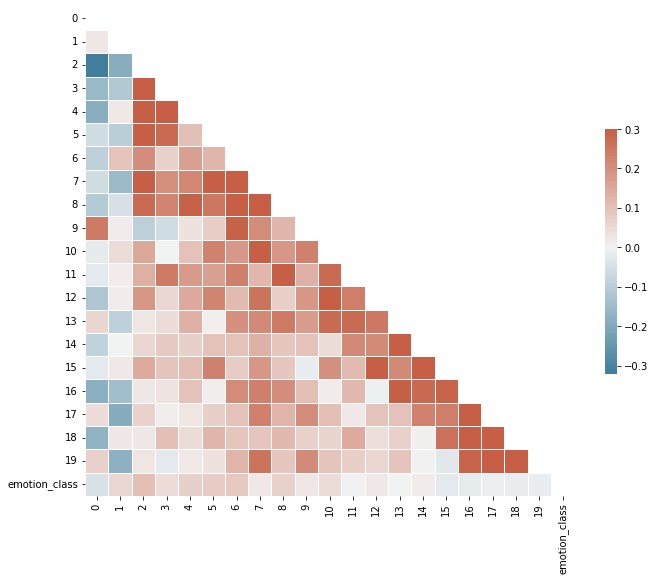

In [414]:
mfcc_corr = mfcc_df.corr()
sea_corr_plot(mfcc_corr)

In [416]:
print_high_corr(mfcc_corr)

1    0.054472
2    0.102191
4    0.067668
5    0.079033
6    0.082737
8    0.065865
Name: emotion_class, dtype: float64


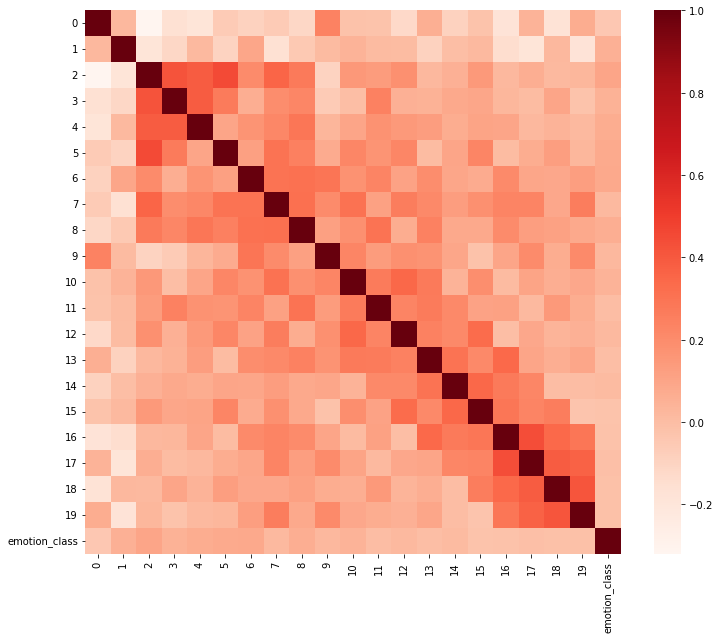

In [417]:
plt.figure(figsize=(12,10))
sns.heatmap(mfcc_corr, cmap=plt.cm.Reds)
plt.show()

### Explore Chroma

In [418]:
chroma_df = pd.DataFrame(chroma)
chroma_df['emotion_class'] = y_train
chroma_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,emotion_class
count,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000,9988.000000
mean,0.617227,0.608869,0.609518,0.612410,0.611866,0.612841,0.621568,0.633957,0.640690,0.642180,0.630193,0.620357,3.555967
std,0.089236,0.089165,0.090553,0.089367,0.089247,0.090418,0.090722,0.091042,0.091204,0.091979,0.092383,0.091417,1.629916
min,0.128144,0.157541,0.135285,0.166397,0.133655,0.182398,0.140724,0.182977,0.184489,0.197983,0.113644,0.094230,0.000000
25%,0.563774,0.553796,0.552234,0.556920,0.555255,0.554928,0.564327,0.575674,0.582343,0.585121,0.572897,0.564222,3.000000
50%,0.621275,0.611266,0.612633,0.614559,0.614074,0.615127,0.624841,0.637845,0.643218,0.646500,0.634768,0.623577,4.000000
75%,0.673976,0.667075,0.668247,0.671275,0.670957,0.673299,0.682330,0.695428,0.702784,0.705380,0.691942,0.681147,4.000000
max,0.988082,0.966686,0.999545,0.981433,1.000000,1.000000,0.997128,0.995705,1.000000,0.991004,0.965591,1.000000,6.000000


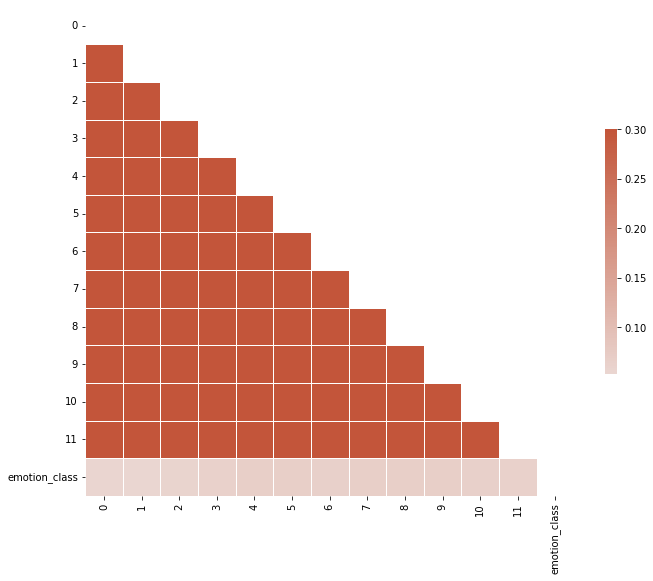

In [419]:
chroma_corr = chroma_df.corr()
sea_corr_plot(chroma_corr)

In [420]:
print_high_corr(chroma_corr)

0     0.056723
1     0.053262
2     0.058706
3     0.061481
4     0.065792
5     0.068019
6     0.064125
7     0.067919
8     0.066308
9     0.067108
10    0.065595
11    0.063321
Name: emotion_class, dtype: float64


# Evaluation

In [41]:
# Determine zero rule baseline on test labels
total_labels = label_counts.sum()
correct = max(label_counts)
max_label = label_counts[label_counts == correct].index[0]
accuracy = correct / total_labels * 100
print(f'predict: {max_label} accuracy: {accuracy:.2f}%')

predict=: neutral. accuracy= 47.15%
